<a href="https://colab.research.google.com/github/luciamartinf/BigData/blob/main/AngelaAlvaroLucia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

#exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl (93.9 MB)


In [2]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *


Prepending /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


In [4]:
import findspark
findspark.init()

In [5]:
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.8/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


In [6]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import datetime as dt
import tempfile

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import pandas as pd
from pathlib import Path

#import sys
#print(os.path.abspath(os.path.join('../neural_networks')))
#sys.path.append(os.path.abspath(os.path.join('../neural_networks')))
#from utils import get_mnist

from bigdl.dllib.nn.layer import *
from bigdl.dllib.nn.criterion import *
from bigdl.dllib.optim.optimizer import *
#from bigdl.util.common import *
#from bigdl.dataset.transformer import *
#from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
from IPython.display import Markdown, display

Populating the interactive namespace from numpy and matplotlib


In [7]:
from bigdl.dllib import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing import image

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Define path to the data directory
dir_alldata = Path('/content/drive/MyDrive/Colab Notebooks/chest_xray')
# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

## Data visualization

Printing three Normal random images 
NORMAL2-IM-0251-0001.jpeg
NORMAL2-IM-0233-0001.jpeg
NORMAL2-IM-0110-0001.jpeg


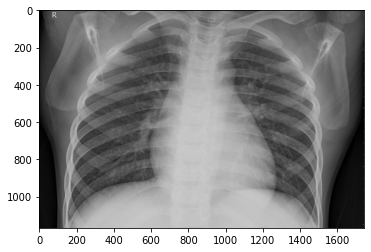

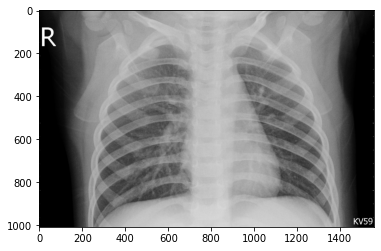

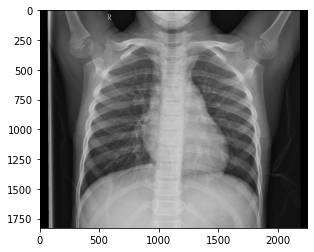

In [10]:
# Three Random Normal CXR Images from the dataset
import os, random

folder_N=r"/content/drive/MyDrive/Colab Notebooks/chest_xray/test/NORMAL"

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 

Printing three Normal random images 
person147_bacteria_711.jpeg
person119_bacteria_568.jpeg
person1634_virus_2830.jpeg


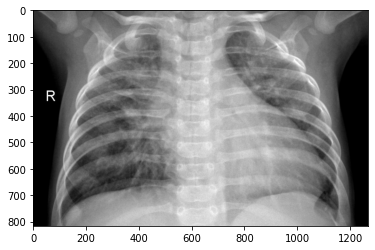

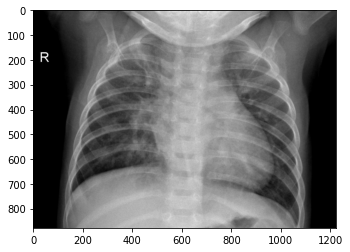

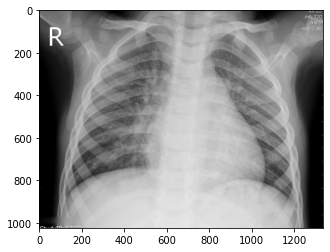

In [11]:
# Three Random Pneumonia CXR Images from the dataset
import os, random

folder_N=r"/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA"

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 
    

## Exploratory analysis
Plot Count of Positive and Negative Cases

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

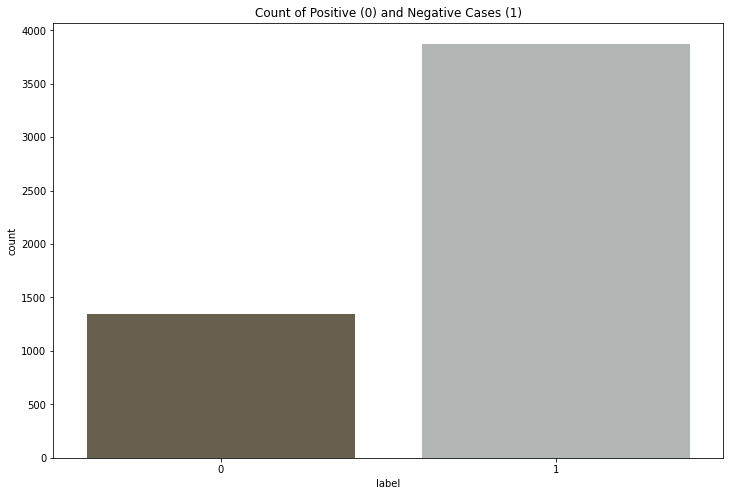

In [12]:
# To plot the count plot I am changing the dataset into a pandas dataframe
# Get the list of all the images
normal = normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
#train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)")


In [13]:
train_df

,image,label
0,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
1,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
2,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
3,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
4,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
...,...,...
5211,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5212,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5213,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5214,/content/drive/MyDrive/Colab Notebooks/chest_x...,1


In [52]:
img_width, img_height = 64,64
nb_train_sample =5216
nb_validation_samples =16
nb_test_samples = 624

#epochs = 50
batch_size = 32

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150), batch_size = 64, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150), batch_size =  batch_size, class_mode="binary")
 
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150), batch_size= batch_size,  class_mode="binary")
 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *


def build_lenet_model():

    model = Sequential()
    model.add(Reshape((3, 150, 150), input_shape=(150, 150, 3)))
    model.add(Convolution2D(6, 5, 5, activation="tanh", name="conv1_5x5"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(12, 5, 5, activation="tanh", name="conv2_5x5"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation="tanh", name="fc1"))
    model.add(Dense(2, activation="softmax", name="fc2")) # 2 classes
    return model

In [16]:
lenet = build_lenet_model()

creating: createZooKerasSequential
creating: createZooKerasReshape
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDense


In [17]:
lenet.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

#model.compile(optimizer="rmsprop",
                  #loss="binary_crossentropy",
                  #metrics=['accuracy'])

creating: createAdadelta
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


In [53]:
ssX_train, ssY_train = next(train_generator)
X_val, Y_val = next(validation_generator)
X_test, Y_test = next(test_generator)

In [19]:
print(X_val.shape)
print(Y_val.shape)

(16, 150, 150, 3)
(16,)


In [20]:
#!pip install tqdm


In [21]:
import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)): 
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)


100%|██████████| 162/162 [02:56<00:00,  1.09s/it]


In [22]:
#!pip freeze

In [23]:
print(X_train.shape)
print(y_train.shape)

#lenet.fit(X_train, y_train, batch_size = 5216)

(5216, 150, 150, 3)
(5216,)


In [24]:
sX_train = X_train[:500]
sy_train = y_train[:500]

In [54]:
lenet.fit(
        ssX_train,ssY_train,
        nb_epoch=20,
        batch_size = 50,
        validation_data=(X_val, Y_val))
        #validation_data=(next(validation_generator)))

In [ ]:
#lenet.fit(
        #X_train,y_train,
        #nb_epoch=2,
        #batch_size = 5216,
        #validation_data=(X_val, Y_val))
        #validation_data=(next(validation_generator)))

In [ ]:
#lenet.fit(
        #next(train_generator)[0], next(train_generator)[1],
        #nb_epoch=50,
        #batch_size = 32,
        #validation_data=(next(validation_generator)))

In [ ]:
#lenet.fit(
        #X_train, Y_train,
        #nb_epoch=300,
        #batch_size = 20,
        #validation_data=(X_val, Y_val))

In [55]:
accuracy = lenet.evaluate(X_test, Y_test, batch_size=20)
print("TestLoss: ", accuracy[0])
print("Accuracy: ", accuracy[1])

TestLoss:  0.4056383967399597
Accuracy:  0.8125


We found out that functions and methods implemented in the bigdl.dllib library are sometimes pretty different from original keras methods and functions which complicated the building of different models implement the bigdl.dllib library. 


Considering these difficulties, we decided to build the lenet model implement the bigdl.dllib library and two other different models using tensorflow 